In [12]:
from datetime import datetime, timedelta

import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ALL_PUBLIC_HOLIDAYS = {
    "2018-08-06",
    "2018-10-29",
    "2018-12-25",
    "2018-12-26",
    "2019-01-01",
    "2019-03-17",
    "2019-04-22",
    "2019-05-06",
    "2019-06-03",
    "2019-08-05",
    "2019-10-28",
    "2019-12-25",
    "2019-12-26",
    "2020-01-01",
    "2020-03-17",
    "2020-04-13",
    "2020-05-04",
    "2020-06-01",
    "2020-08-03",
    "2020-10-26",
    "2020-12-25",
    "2020-12-26",
    "2021-01-01",
    "2020-03-17",
    "2020-04-05",
    "2020-05-03",
    "2020-06-07",
    "2020-08-02",
    "2020-10-25",
    "2020-12-25",
    "2020-12-26",
    "2021-01-01",
    "2021-03-17",
    "2021-03-18",
    "2021-04-18",
    "2021-05-02",
    "2021-06-06",
    "2021-08-01",
    "2021-10-31",
    "2021-12-25",
    "2021-12-26",
    "2022-01-01",
    "2022-03-17",
    "2022-03-18",
    "2022-04-18",
    "2022-05-02",
    "2022-06-06",
    "2022-08-01",
    "2022-10-31",
    "2022-12-25",
    "2022-12-26",
    "2023-01-01",
    "2023-02-06",
    "2023-03-17",
    "2023-04-10",
    "2023-05-01",
    "2023-06-05",
    "2023-08-07",
    "2023-10-30",
    "2023-12-25",
    "2023-12-26",
}

In [3]:
def weekends_by_year(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    weekends = set()

    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() in [5, 6]:  # 5 is Saturday, 6 is Sunday
            weekends.add(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)

    return weekends

In [5]:
ALL_WEEKENDS = set()
for year in (2018, 2019, 2020, 2021, 2022, 2023):
    ALL_WEEKENDS.update(weekends_by_year(year))

def check_weekend(date_obj):
    return int(date_obj.strftime('%Y-%m-%d') in ALL_WEEKENDS)

def check_public_holiday(date_obj):
    return int(date_obj.strftime('%Y-%m-%d') in ALL_PUBLIC_HOLIDAYS)

In [6]:
DATASET_ORG_DIR = "dataset_org"
SELECTED_COLUMNS = ["STATION ID", "TIME", "BIKE STANDS", "AVAILABLE BIKE STANDS"]
WEATHER_FILE = "weather.csv"

In [10]:
BASE_DIR = os.getcwd()
print(BASE_DIR)

c:\Users\malli\Downloads\Programming for DA\ipynb files


In [ ]:
BASE_DIR = os.getcwd()  # Get the current working directory
DATASET_ORG_DIR = os.path.join(BASE_DIR, "dataset_org")  # Append the dataset folder to the base directory

SELECTED_COLUMNS = ["TIME", "STATION ID", "BIKE STANDS", "AVAILABLE BIKE STANDS"]

# Global variable to store the processed data
combined_csv_df = pd.DataFrame()

if not os.path.exists(DATASET_ORG_DIR):
    print(f"Directory '{DATASET_ORG_DIR}' does not exist! Please check the folder location.")
else:
    print(f"Dataset directory set to: {DATASET_ORG_DIR}")

def process_data_with_memory_monitoring():
    """
    Function to process CSV files and compute combined data.
    Also monitors memory usage.
    """
    global combined_csv_df  # Use the global variable to store the processed data
    combined_csv_list = []
    print("PROCESSING FILES:")
    file_list = [file for file in os.listdir(DATASET_ORG_DIR) if "dublinbikes" in file or "dublinbike-" in file]
    
    if not file_list:
        print("No CSV files found in the directory!")
        sys.exit(0)  # Exit gracefully if no files are found

    for file in file_list:
        print(f"{os.path.join(DATASET_ORG_DIR, file)}")
        df = pd.read_csv(os.path.join(DATASET_ORG_DIR, file))
        df["TIME"] = pd.to_datetime(df["TIME"])

        # Workaround for different labels in monthly CSVs
        if "BIKE STANDS" in df:
            quarterly = True
        else:
            print("    + label corrections")
            df.rename(columns={"BIKE_STANDS": "BIKE STANDS", "AVAILABLE_BIKE_STANDS": "AVAILABLE BIKE STANDS"}, inplace=True)
            quarterly = False

        df = df[SELECTED_COLUMNS]

        group_dfs = {station_id: group_df for station_id, group_df in df.groupby("STATION ID")}
        res = []
        print("    + combine CSV for all station ids")
        for station_id, group_df in group_dfs.items():
            if quarterly:
                group_df = group_df.iloc[::6].copy()

            group_df = group_df.drop(["STATION ID"], axis=1)

            group_df["USAGE"] = group_df["AVAILABLE BIKE STANDS"].diff().abs()

            group_df.set_index("TIME", inplace=True)
            group_df = group_df.resample("h").sum()  # Changed to 'h' to avoid warnings

            group_df.reset_index(drop=False, inplace=True)
            res.append(group_df)

        group_dfs_hourly = pd.concat(res, ignore_index=True)
        group_dfs_hourly.dropna(inplace=True)
        combined_csv_list.append(group_dfs_hourly)

    combined_csv_df = pd.concat(combined_csv_list, ignore_index=False)  # Store in global variable
    print("Processing completed successfully!")
    return combined_csv_df

# Process the data
start_time = time.time()

# Monitor memory usage while processing
mem_usage = memory_usage(process_data_with_memory_monitoring)
print(f"Memory usage during processing: {max(mem_usage)} MB")

end_time = time.time()
print(f"Time taken for processing: {end_time - start_time} seconds")

# The `combined_csv_df` is now globally accessible


Dataset directory set to: c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org
PROCESSING FILES:
c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org\dublinbike-historical-data-2022-01.csv
    + label corrections
    + combine CSV for all station ids
c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org\dublinbike-historical-data-2022-02.csv
    + label corrections
    + combine CSV for all station ids
c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org\dublinbike-historical-data-2022-03.csv
    + label corrections
    + combine CSV for all station ids
c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org\dublinbike-historical-data-2022-04.csv
    + label corrections
    + combine CSV for all station ids
c:\Users\malli\Downloads\Programming for DA\ipynb files\dataset_org\dublinbike-historical-data-2022-05.csv
    + label corrections
    + combine CSV for all station ids
c:\Users\malli\Downloads\Programming for DA

In [16]:
# take total entries for that hour across all stations
station_avg_df = combined_csv_df.groupby("TIME").sum()
station_avg_df.reset_index(drop=False, inplace=True)


In [17]:
# add weekend column
station_avg_df["WEEKEND"] = station_avg_df["TIME"].apply(check_weekend)

In [18]:
# add public holiday column
station_avg_df["PUBLIC HOLIDAY"] = station_avg_df["TIME"].apply(check_public_holiday)

In [19]:
# add utilization column
station_avg_df["UTILIZATION"] = (station_avg_df["AVAILABLE BIKE STANDS"] / station_avg_df["BIKE STANDS"]).round(2)


In [ ]:
# Define the dataset directory
DATASET_ORG_DIR = r"C:/Users/malli/Downloads/Programming for DA/ipynb files/dataset_org"

# Define the file name
weather_file = "hly532.csv"

# Load the weather CSV
weather_df = pd.read_csv(os.path.join(DATASET_ORG_DIR, weather_file))

# Display the first few rows to confirm it loaded correctly
print(weather_df.head())


C:\Users\malli\AppData\Local\Temp\ipykernel_15352\1632681358.py:10: DtypeWarning: Columns (8,9,14,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv(os.path.join(DATASET_ORG_DIR, weather_file))


               date  ind  rain  ind.1  temp  ind.2  wetb  dewpt vappr rhum  \
0  01/01/1944 00:00    2   0.0      0   7.2      0   6.7    6.1   9.4   93   
1  01/01/1944 01:00    0   0.0      0   7.2      0   6.6    6.1   9.3   91   
2  01/01/1944 02:00    2   0.0      0   7.2      0   6.6    6.1   9.3   92   
3  01/01/1944 03:00    2   0.0      0   7.2      0   6.5    5.5   9.1   90   
4  01/01/1944 04:00    0   0.0      0   7.2      0   6.5    5.5   9.1   89   

   ...  ind.3  wdsp  ind.4  wddir  ww  w  sun    vis clht clamt  
0  ...      1    19      1    290  50  5  0.0  20000   12     8  
1  ...      1    19      1    280   2  2  0.0  30000   15     7  
2  ...      1    19      1    260  50  5  0.0  30000   15     8  
3  ...      1    19      1    270  50  5  0.0  20000   15     7  
4  ...      1    19      1    270   2  2  0.0  30000   18     7  

[5 rows x 21 columns]


In [23]:
station_avg_df.head()

,TIME,BIKE STANDS,AVAILABLE BIKE STANDS,USAGE,WEEKEND,PUBLIC HOLIDAY,UTILIZATION
0,2018-08-01 12:00:00,3515,2196,0.0,0,0,0.62
1,2018-08-01 13:00:00,7030,4419,260.0,0,0,0.63
2,2018-08-01 14:00:00,7030,4365,365.0,0,0,0.62
3,2018-08-01 15:00:00,7030,4475,530.0,0,0,0.64
4,2018-08-01 16:00:00,7030,4731,956.0,0,0,0.67


In [24]:
# Merge both datasets
weather_df["date"] = pd.to_datetime(weather_df["date"], format='%d/%m/%Y %H:%M')  # Correct format
weather_df.set_index("date", inplace=True)

station_avg_df.set_index("TIME", inplace=True)
station_avg_df = pd.merge(
    station_avg_df,
    weather_df[["rain", "temp", "wetb", "rhum", "wdsp", "sun", "vis", "clht", "clamt"]],
    left_index=True,
    right_index=True,
    how='left'
)
station_avg_df.reset_index(drop=False, inplace=True)
station_avg_df.dropna(inplace=True)


In [25]:
# add time columns
station_avg_df.insert(0, 'WEEKDAY', station_avg_df['TIME'].dt.weekday)
station_avg_df.insert(0, 'YEAR', station_avg_df['TIME'].dt.year)
station_avg_df.insert(0, 'MONTH', station_avg_df['TIME'].dt.month)
station_avg_df.insert(0, 'DAY', station_avg_df['TIME'].dt.day)
station_avg_df.insert(0, 'HOUR', station_avg_df['TIME'].dt.hour)

In [26]:
# add mean to missing data points
station_avg_df.set_index("TIME", inplace=True)
new_index = pd.date_range(start=station_avg_df.index.min(), end=station_avg_df.index.max(), freq="1H")
station_avg_df = station_avg_df.reindex(new_index)

In [27]:
print(station_avg_df.dtypes)


HOUR                     float64
DAY                      float64
MONTH                    float64
YEAR                     float64
WEEKDAY                  float64
BIKE STANDS              float64
AVAILABLE BIKE STANDS    float64
USAGE                    float64
WEEKEND                  float64
PUBLIC HOLIDAY           float64
UTILIZATION              float64
rain                     float64
temp                     float64
wetb                     float64
rhum                      object
wdsp                     float64
sun                      float64
vis                       object
clht                      object
clamt                     object
dtype: object


In [28]:
station_avg_df.isna().sum()

HOUR                     1516
DAY                      1516
MONTH                    1516
YEAR                     1516
WEEKDAY                  1516
BIKE STANDS              1516
AVAILABLE BIKE STANDS    1516
USAGE                    1516
WEEKEND                  1516
PUBLIC HOLIDAY           1516
UTILIZATION              1516
rain                     1516
temp                     1516
wetb                     1516
rhum                     1516
wdsp                     1516
sun                      1516
vis                      1516
clht                     1516
clamt                    1516
dtype: int64

In [29]:
# Get the number of rows and columns
rows, columns = station_avg_df.shape

# Print the result
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")


Number of rows: 48924
Number of columns: 20


In [30]:
# Fill missing datapoints with mean for numeric columns only
mean_values = station_avg_df.select_dtypes(include=['number']).mean()
station_avg_df = station_avg_df.fillna(mean_values)

# Verify if missing values are filled
print(station_avg_df.isnull().sum())


HOUR                        0
DAY                         0
MONTH                       0
YEAR                        0
WEEKDAY                     0
BIKE STANDS                 0
AVAILABLE BIKE STANDS       0
USAGE                       0
WEEKEND                     0
PUBLIC HOLIDAY              0
UTILIZATION                 0
rain                        0
temp                        0
wetb                        0
rhum                     1516
wdsp                        0
sun                         0
vis                      1516
clht                     1516
clamt                    1516
dtype: int64


In [31]:
for col in station_avg_df.select_dtypes(include=['object']).columns:
    if station_avg_df[col].nunique() < 10:  # If categorical with few unique values
        station_avg_df[col].fillna(station_avg_df[col].mode()[0], inplace=True)
    else:
        station_avg_df[col].fillna('Unknown', inplace=True)

# Verify if all missing values are filled
print(station_avg_df.isnull().sum())


HOUR                     0
DAY                      0
MONTH                    0
YEAR                     0
WEEKDAY                  0
BIKE STANDS              0
AVAILABLE BIKE STANDS    0
USAGE                    0
WEEKEND                  0
PUBLIC HOLIDAY           0
UTILIZATION              0
rain                     0
temp                     0
wetb                     0
rhum                     0
wdsp                     0
sun                      0
vis                      0
clht                     0
clamt                    0
dtype: int64


In [32]:
# drop BIKE STANDS and UTILIZATION columns
station_avg_df = station_avg_df.drop(["BIKE STANDS", "AVAILABLE BIKE STANDS", "UTILIZATION"], axis=1)



In [33]:
station_avg_df.to_csv(f"combined1.csv", index_label="TIME")

In [34]:
def load_and_inspect_data(file_path):
    """Load the dataset and inspect its structure."""
    try:
        df = pd.read_csv(file_path)
        print("Data loaded successfully.")
        print("\nFirst five rows:")
        print(df.head())
        print("\nData Information:")
        df.info()
        print("\nDescriptive Statistics:")
        print(df.describe())
        print("\nMissing Values:")
        print(df.isnull().sum())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


data_path = 'combined1.csv'
df = load_and_inspect_data(data_path)

Data loaded successfully.

First five rows:
                  TIME  HOUR  DAY  MONTH    YEAR  WEEKDAY  USAGE  WEEKEND  \
0  2018-08-01 12:00:00  12.0  1.0    8.0  2018.0      2.0    0.0      0.0   
1  2018-08-01 13:00:00  13.0  1.0    8.0  2018.0      2.0  260.0      0.0   
2  2018-08-01 14:00:00  14.0  1.0    8.0  2018.0      2.0  365.0      0.0   
3  2018-08-01 15:00:00  15.0  1.0    8.0  2018.0      2.0  530.0      0.0   
4  2018-08-01 16:00:00  16.0  1.0    8.0  2018.0      2.0  956.0      0.0   

   PUBLIC HOLIDAY  rain  temp  wetb rhum  wdsp  sun    vis clht clamt  
0             0.0   3.2  15.1  14.5   93   6.0  0.0   4000   20     8  
1             0.0   2.2  15.6  15.2   96   5.0  0.0  12000   15     8  
2             0.0   0.0  17.1  15.2   81   6.0  0.0  20000   15     8  
3             0.0   0.0  17.4  15.2   78  11.0  0.0  20000   25     8  
4             0.0   0.0  17.7  15.5   78  11.0  0.0  20000   25     8  

Data Information:
<class 'pandas.core.frame.DataFrame'>
Rang

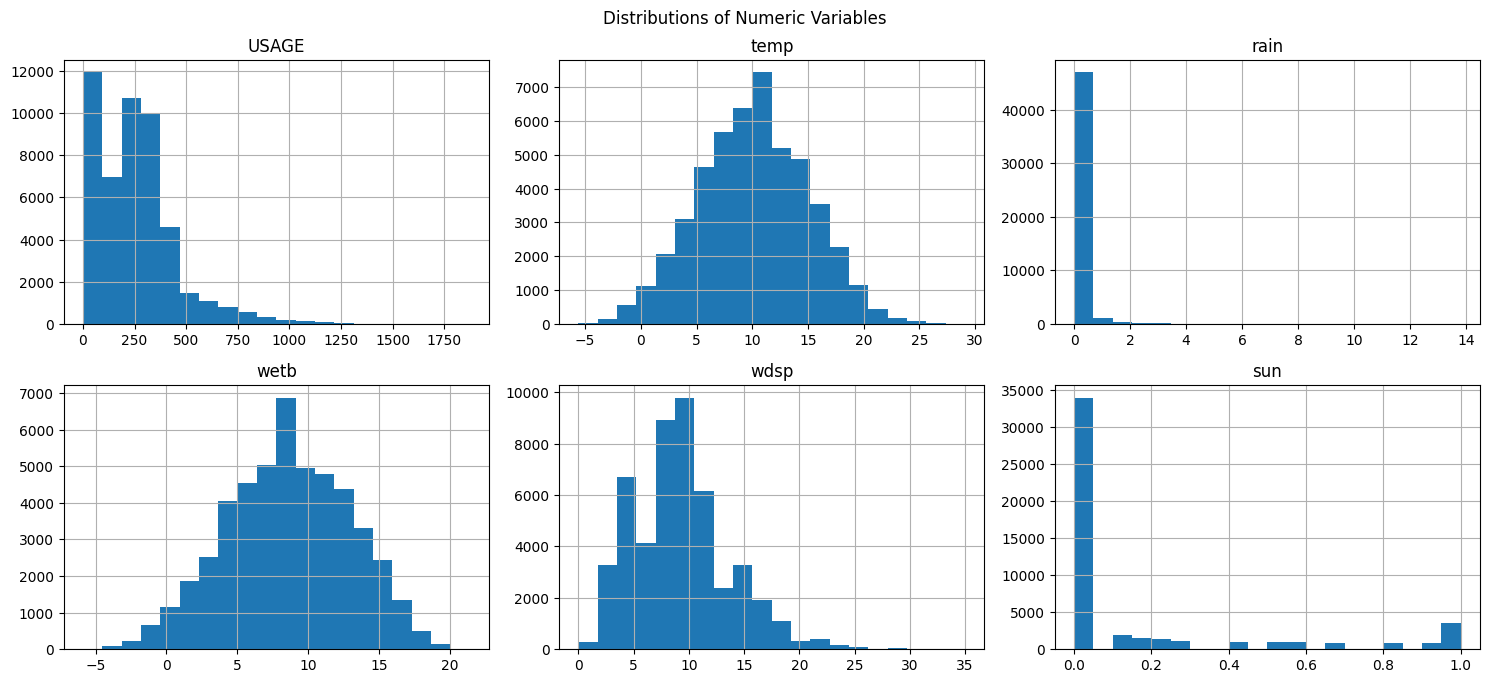

In [ ]:
#Plot histograms for specified columns.
def plot_distributions(df, columns):
    df[columns].hist(bins=20, figsize=(15, 10), layout=(len(columns)//3 + 1, 3))
    plt.suptitle("Distributions of Numeric Variables")
    plt.tight_layout()
    plt.show()

numeric_columns = ['USAGE', 'temp', 'rain', 'wetb', 'wdsp', 'sun']
plot_distributions(df, numeric_columns)


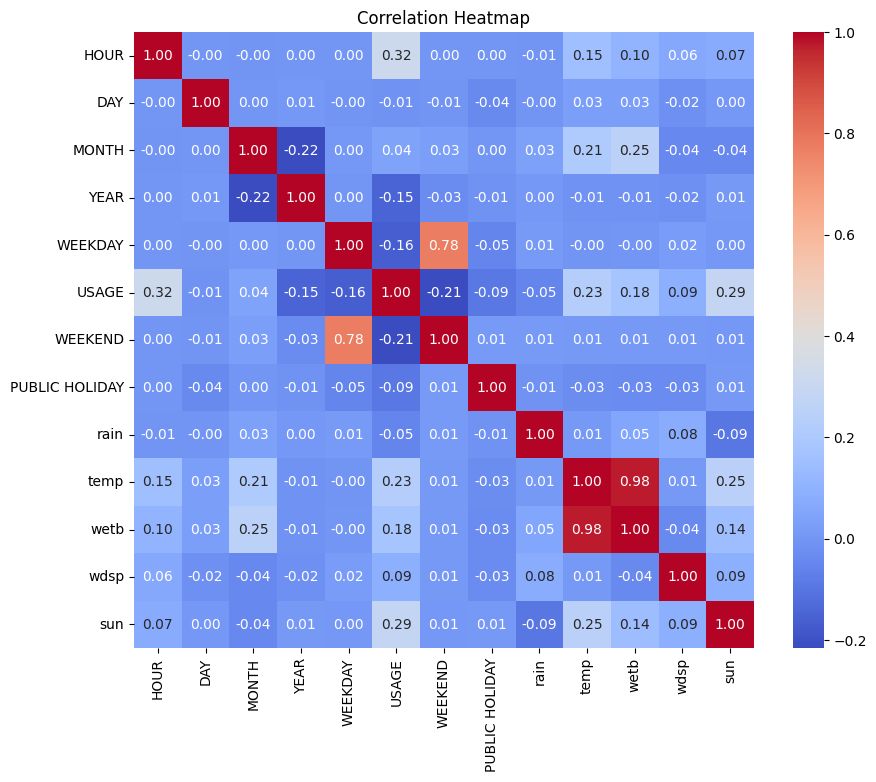

In [ ]:
#Plot a correlation heatmap for numeric columns.
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['number'])
    
    # Compute correlation matrix
    correlation_matrix = numeric_df.corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.show()


plot_correlation_heatmap(df)


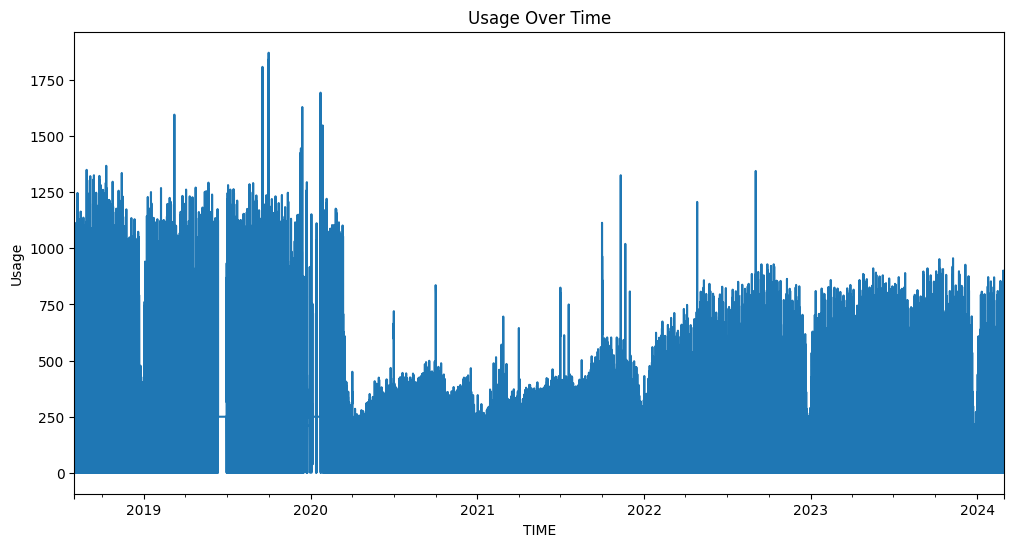

In [38]:
#Plot time series trends for 'USAGE'
def plot_time_series(df):
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.set_index('TIME', inplace=True)
    df['USAGE'].plot(figsize=(12, 6), title="Usage Over Time")
    plt.ylabel("Usage")
    plt.show()

plot_time_series(df)


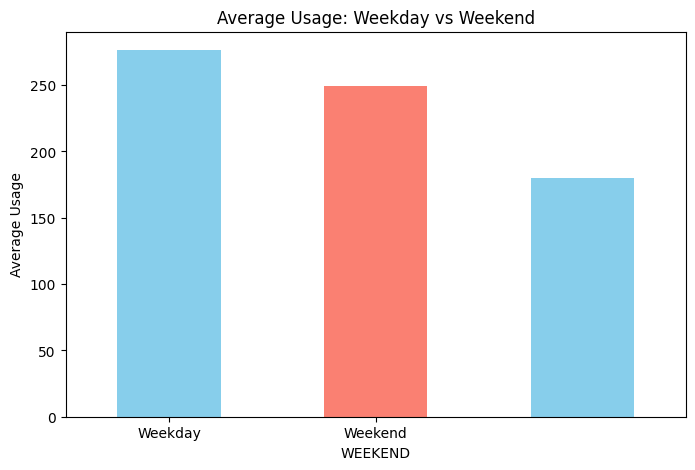

In [39]:
#Compare weekday and weekend usage.
def plot_weekday_vs_weekend(df):
    avg_usage = df.groupby('WEEKEND')['USAGE'].mean()
    avg_usage.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'], title="Average Usage: Weekday vs Weekend")
    plt.xticks([0, 1], labels=["Weekday", "Weekend"], rotation=0)
    plt.ylabel("Average Usage")
    plt.show()

plot_weekday_vs_weekend(df)


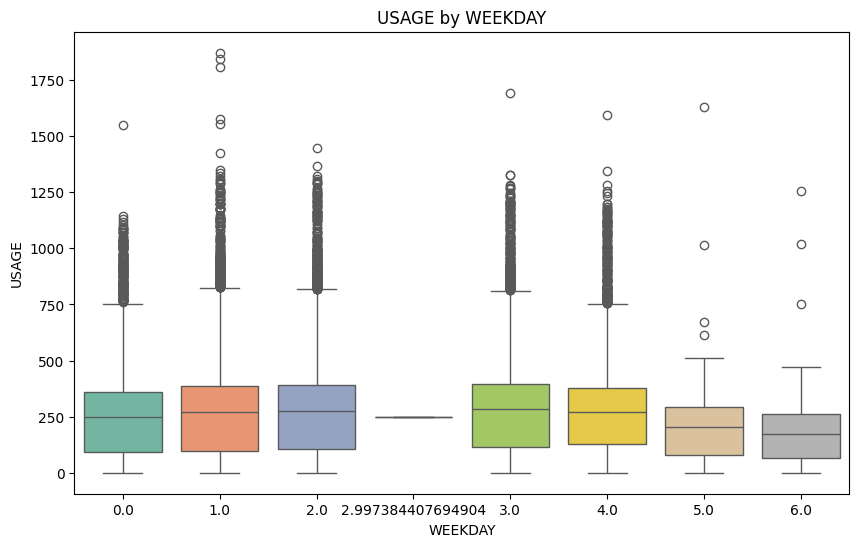

In [40]:
#Plot a boxplot for the specified column against 'USAGE'
def plot_boxplot(df, column, y):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, y=y, data=df, palette='Set2')
    plt.title(f"{y} by {column}")
    plt.show()

plot_boxplot(df, column='WEEKDAY', y='USAGE')


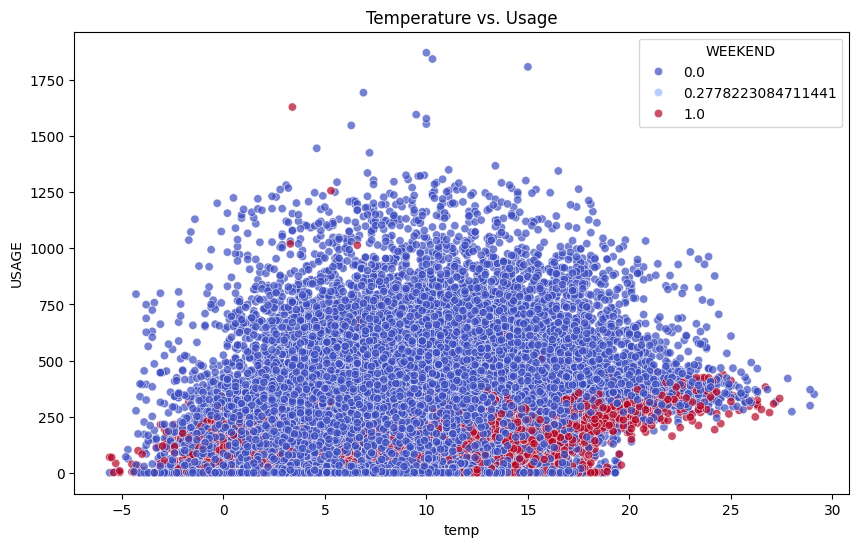

In [41]:
#Scatter plot for 'temp' vs 'USAGE'

def plot_temp_vs_usage(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='temp', y='USAGE', data=df, hue='WEEKEND', palette='coolwarm', alpha=0.7)
    plt.title("Temperature vs. Usage")
    plt.show()

plot_temp_vs_usage(df)


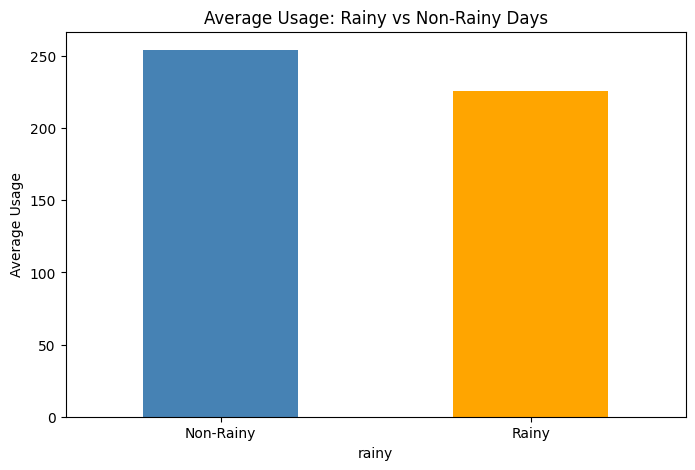

In [42]:
def plot_rain_vs_usage(df):
    df['rainy'] = df['rain'] > 0
    avg_usage_rain = df.groupby('rainy')['USAGE'].mean()
    avg_usage_rain.plot(kind='bar', figsize=(8, 5), color=['steelblue', 'orange'], title="Average Usage: Rainy vs Non-Rainy Days")
    plt.xticks([0, 1], labels=["Non-Rainy", "Rainy"], rotation=0)
    plt.ylabel("Average Usage")
    plt.show()

plot_rain_vs_usage(df)


In [44]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 1515


In [45]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48924 entries, 2018-08-01 12:00:00 to 2024-02-29 23:00:00
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HOUR            48924 non-null  float64
 1   DAY             48924 non-null  float64
 2   MONTH           48924 non-null  float64
 3   YEAR            48924 non-null  float64
 4   WEEKDAY         48924 non-null  float64
 5   USAGE           48924 non-null  float64
 6   WEEKEND         48924 non-null  float64
 7   PUBLIC HOLIDAY  48924 non-null  float64
 8   rain            48924 non-null  float64
 9   temp            48924 non-null  float64
 10  wetb            48924 non-null  float64
 11  rhum            48924 non-null  object 
 12  wdsp            48924 non-null  float64
 13  sun             48924 non-null  float64
 14  vis             48924 non-null  object 
 15  clht            48924 non-null  object 
 16  clamt           48924 non-null  object 
 

In [46]:
# 4. Data Structures
def save_to_json(df, file_path):
    try:
        df.to_json(file_path, orient='records', lines=True)
        print(f"Data successfully saved to {file_path}.")
    except Exception as e:
        print(f"Error saving data to JSON: {e}")

# Save cleaned data to JSON
json_path = 'cleaned_data.json'
save_to_json(df, json_path)

# Loading data from JSON (example)
def load_from_json(file_path):
    try:
        df = pd.read_json(file_path, orient='records', lines=True)
        print("Data loaded from JSON successfully.")
        return df
    except Exception as e:
        print(f"Error loading JSON data: {e}")
        return None

df_json = load_from_json(json_path)

# Verify loaded data
print("\nData loaded from JSON:")
print(df_json.head())

Data successfully saved to cleaned_data.json.
Data loaded from JSON successfully.

Data loaded from JSON:
   HOUR  DAY  MONTH    YEAR  WEEKDAY  USAGE  WEEKEND  PUBLIC HOLIDAY  rain  \
0  12.0  1.0    8.0  2018.0      2.0    0.0      0.0             0.0   3.2   
1  13.0  1.0    8.0  2018.0      2.0  260.0      0.0             0.0   2.2   
2  14.0  1.0    8.0  2018.0      2.0  365.0      0.0             0.0   0.0   
3  15.0  1.0    8.0  2018.0      2.0  530.0      0.0             0.0   0.0   
4  16.0  1.0    8.0  2018.0      2.0  956.0      0.0             0.0   0.0   

   temp  wetb rhum  wdsp  sun    vis clht clamt  rainy  
0  15.1  14.5   93   6.0  0.0   4000   20     8   True  
1  15.6  15.2   96   5.0  0.0  12000   15     8   True  
2  17.1  15.2   81   6.0  0.0  20000   15     8  False  
3  17.4  15.2   78  11.0  0.0  20000   25     8  False  
4  17.7  15.5   78  11.0  0.0  20000   25     8  False  


In [49]:
df.head()

,HOUR,DAY,MONTH,YEAR,WEEKDAY,USAGE,WEEKEND,PUBLIC HOLIDAY,rain,temp,wetb,rhum,wdsp,sun,vis,clht,clamt,rainy
TIME,,,,,,,,,,,,,,,,,,
2018-08-01 12:00:00,12.0,1.0,8.0,2018.0,2.0,0.0,0.0,0.0,3.2,15.1,14.5,93,6.0,0.0,4000,20,8,True
2018-08-01 13:00:00,13.0,1.0,8.0,2018.0,2.0,260.0,0.0,0.0,2.2,15.6,15.2,96,5.0,0.0,12000,15,8,True
2018-08-01 14:00:00,14.0,1.0,8.0,2018.0,2.0,365.0,0.0,0.0,0.0,17.1,15.2,81,6.0,0.0,20000,15,8,False
2018-08-01 15:00:00,15.0,1.0,8.0,2018.0,2.0,530.0,0.0,0.0,0.0,17.4,15.2,78,11.0,0.0,20000,25,8,False
2018-08-01 16:00:00,16.0,1.0,8.0,2018.0,2.0,956.0,0.0,0.0,0.0,17.7,15.5,78,11.0,0.0,20000,25,8,False


In [50]:
print(df.columns)


Index(['HOUR', 'DAY', 'MONTH', 'YEAR', 'WEEKDAY', 'USAGE', 'WEEKEND',
       'PUBLIC HOLIDAY', 'rain', 'temp', 'wetb', 'rhum', 'wdsp', 'sun', 'vis',
       'clht', 'clamt', 'rainy'],
      dtype='object')
